<a href="https://colab.research.google.com/github/mishc9/dle-notebooks/blob/master/triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triplet loss: учим нейросеть узнавать объекты с первого раза.


План занятия (что будем делать):
* Рассмотрим проблему similarity learning.
* Разберемся, что такое siamese networks и triplet loss.
* Научимся работать с tensorflow datasets.
* Обучим нейросеть, способную с первого раза узнавать объекты.

## Recap

### Feature extractor
Часть вашей модели или паплайна, которая выполняет *извлечение признаков*: обрабатывает "сырые" данные и извлекает информативные и, желательно, не повторяющие друг друга признаки. Как правило, размерность признаков << размерности данных.

В современном компьютерном зрении под feature extractor'ом обычно подразумевают выход последего из сверточных слоев нейросети.

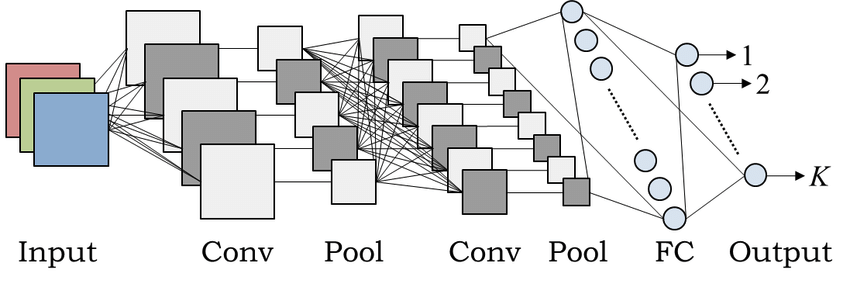

### Косинусное расстояние, евклидово расстояние, cosine similarity



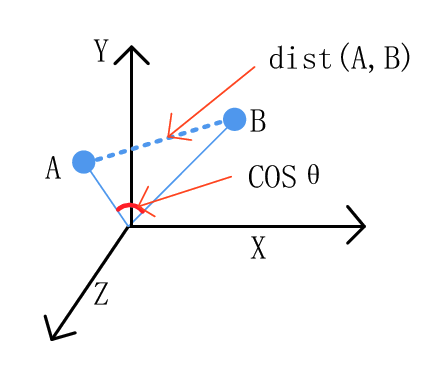

**Евклидово расстояние**  
$d(p, q) = d(q, p) = \sqrt{(p_1- q_1)^2 + (p_2 - q_2)^2 + \cdots +(p_i - q_i)^2+\cdots+(p_n - q_n)^2} = \sqrt{\sum_{i=1}^n {(p_i-q_i)^2}}$

**l2-норма**  
$||p||_2 = \sqrt{p_1^2 + p_2^2 + \cdots + q_i^2+ \cdots +p_n^2} = \sqrt{\sum_{i=1}^n {p_i^2}}$

**Cosine similarity**  
$cos(\theta) = \frac{A \cdot B}{||A||_2||B||_2}$

## Постановка задачи




> Что будет, если мы будем решать задачу распознавания лиц (например) при помощи классификации?


**Подход через классификацию**
* Задача классификации: обучаем нейросеть присваивать вероятность принадлежности объекта к одному из классов
* К сожалению, количество классов заранее определено. В ситуации с распознаванием лиц нам придется добавлять новые классы.

**Проблемы**
* Нам нужно обучить классификатор с *очень* крупным последним слоем: например, $1024 \times n$, где $n$ (в рамках компании среднего размера) может быть $2000-3000$ тысячи
* Увольнение сотрдуника решается довольно "легко" - удаляем часть матрицы. А добавление? Дообучить модель, не *изменяя* веса всех остальных классов, как правило, нельзя. Поэтому приходится обучать заново довольно крупный выходной слой, если не всю модель.
* При этом у вас может не быть большого количества фото новых сотрудников: скорее, 1-2 фото.
* Обучить модель различать двух новых, возможно, похожих людей в таких условиях непросто: выборка по новым классам слишком мала.

## Сиамские сети (Siamese Network)

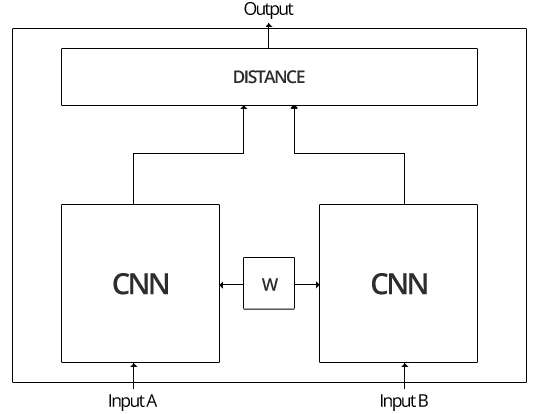

### Triplet Loss

[Статья FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832) - в ней вводится triplet loss.

$L(A, P, N) = max(0, ||f(A) - f(P)||^2 - ||f(A) - f(N)||^2 + \alpha)  $

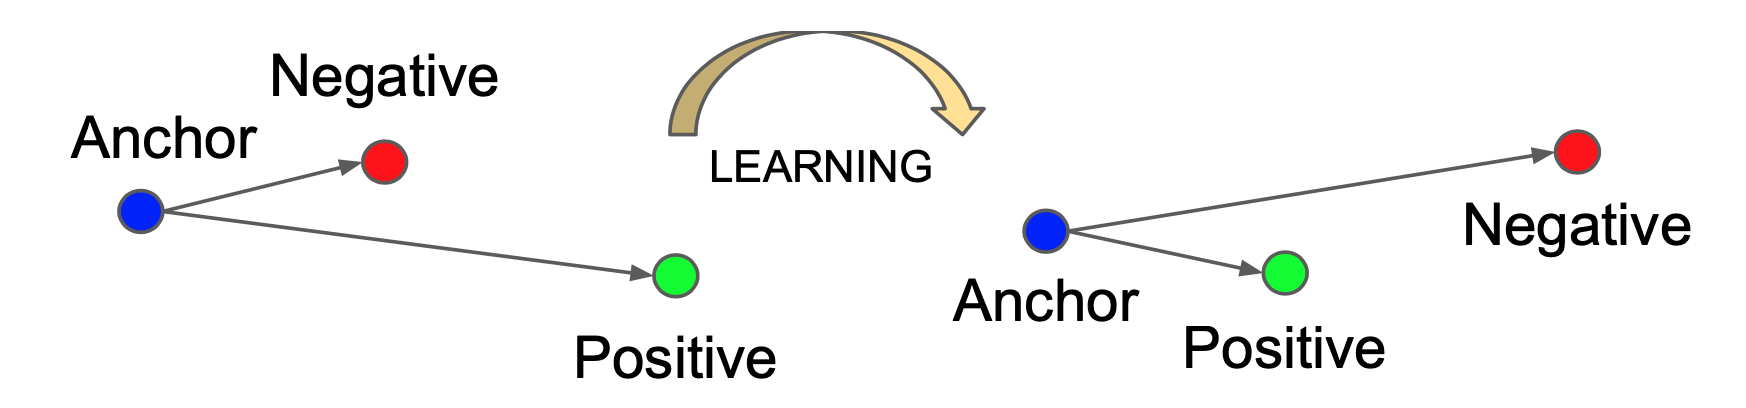

## Semi-hard negative mining
* Простые триплеты - триплеты с лоссом 0, т.к. $d(a,p) + \alpha < d(a,n)$
* Сложные триплеты (hard triplets - : триплеты, в которых отрицательный пример ближе, чем положительный: $d(a,n) < d(a,p)$
* semi-hard triplets - триплеты, в которых отрицательый пример дальше, чем положительный, но все еще в пределах margin $\alpha$: $d(a,p) < d(a,n) < d(a,p)+ \alpha$

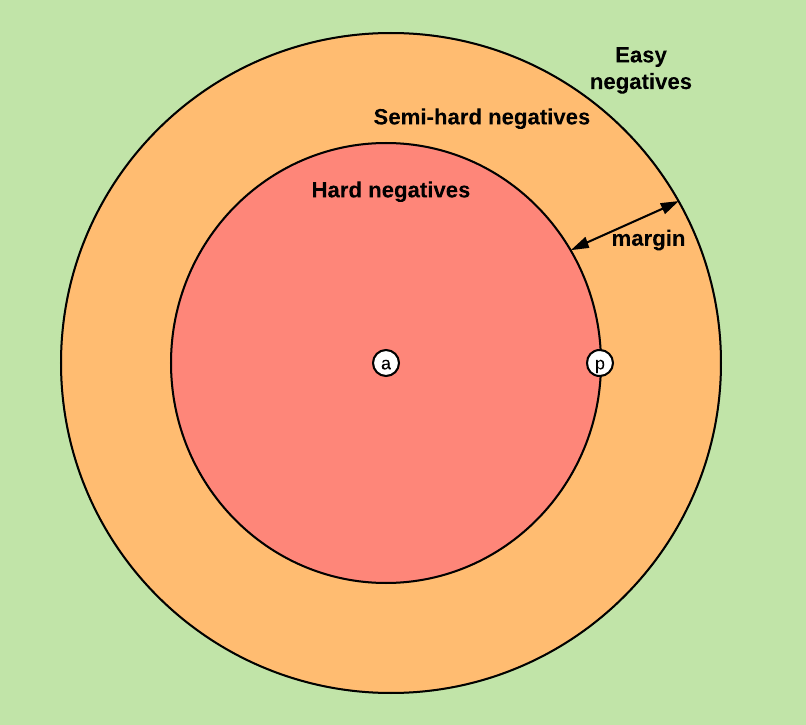

[Катинка отсюда](https://omoindrot.github.io/triplet-loss)

* Если сеть будет учиться на hard negatives, она может застрять в неудачном локальном минимуме.
* semi-hard negatives помогли избежать этой проблемы.
* В статье [FaceNet](https://arxiv.org/abs/1503.03832) использовали выбор случайного semi-hard примера для каждой пары "якорь-положительное значение".

## Стратегии подбора примеров
* Оффлайн - стратегия: триплеты примеров генерируются в начале каждой эпохи
* Онлайн: для каждого батча создается $bs^3$ триплетов. Из них отбираются релевантные (2p, 1n). Дальше есть две стратегии:
  * batch all: усредняем лосс от всех (и hard, и semi-hard) примеров. При этом нужно игнорировать easy triplets: те, у которых лосс равен нулю
  * batch hard: для каждого из якорей в батче находим hardest positive и hardest negative.



# Практическая часть

In [0]:
!pip3 install tensorflow-datasets
!pip install -q --no-deps tensorflow-addons~=0.7

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## Triplet loss - keras

In [0]:
import tensorflow as tf


@tf.function
def triplet_loss(a_pred, p_pred, n_pred, margin):
    positive_distance = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(a_pred - p_pred), axis=-1))
    negative_distance = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(a_pred - n_pred), axis=-1))
    loss = tf.math.maximum(0.0, positive_distance - negative_distance + margin)
    return loss


class TripletLoss(tf.keras.layers.Layer):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.embedding = BaseEmbedding()
        self.margin = margin

    def call(self, anchor, positive, negative):
        self.add_loss(triplet_loss(anchor, positive, negative, self.margin))
        return (anchor, positive, negative)
    
    def get_config(self):
        return {"margin": self.margin}

In [0]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, inp_shape):
        super().__init__()
        self.W = tf.Variable(inp_shape)  # 
        self.b = tf.Variable(inp_shape[0])

    def call(self, x):
        self.add_loss(tf.linalg.l2_normalize(self.W))
        return self.W @ x + self.b

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Utils

In [0]:
def make_model(img_shape, num_classes, model=None):
  """
  Создаем модель. По умолчанию - InceptionResNetV2.
  Если передан конструктор model, используется он (должен поддерживать 
  интерфейс keras.applications).
  
  Из созданного экземпляра модели (в котором нет выходного слоя, т.е. это
  feature extractor) создается модель, которая будет обучаться.

  (Добавляется GlobalAveragePooling2D и два полносвязных слоя с дропаутом).
  """
  if model is None:
    model = keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')
  else:
    model = model(include_top=False, weights='imagenet')
  for layer in model.layers:
    layer.trainable = False
  input = keras.layers.Input(img_shape)
  custom_model = model(input)
  custom_model = keras.layers.GlobalAveragePooling2D()(custom_model)
  custom_model = keras.layers.Dense(64, activation='relu')(custom_model)
  custom_model = keras.layers.Dropout(0.5)(custom_model)
  predictions = keras.layers.Dense(num_classes, activation='softmax')(custom_model)
  return keras.Model(input, predictions)


def make_feature_extractor(model, crop_layers):
  """
  Делаем feature_extractor из модели model, отбрасывая crop_layers слоев.
  """
  inp = model.input
  output = model.layers[-(crop_layers+1)].output
  return keras.Model(inp, output)


def make_tsne_plot_from_vectors(vectors, labels=None, figsize=(6, 4.5)):
  """
  Эта функция строит t-SNE и рисует plt.scatterplot.
  Опцилнально plt.scatterplot аннотирован метками labels.
  """
  tsne_results = TSNE(n_components=2,
                      verbose=1,
                      metric='euclidean').fit_transform(vectors) 

  cmap = plt.cm.get_cmap('coolwarm')
  plt.figure(figsize=figsize, dpi=80)
  scatter = plt.scatter(tsne_results[:, 0],
                        tsne_results[:, 1], 
                        c=labels, 
                        cmap=cmap)
  if labels is not None:
    plt.colorbar(scatter)
  plt.show()


def make_pca_then_tsne_plot(vectors, labels=None):
  """
  На основе веторов vectors сначала делаем PCA, затем tsne.
  labels - метки, используемые для аннотации plt.scatterplot.
  """
  # Следующая строчка нужна, чтобы PCA можно было выполнить, когда размерность
  # целевого пространства была задана больше, чем количество векторов.
  # Мы сокращаем ее до количества векторов.
  pca_dimension = min(100, len(vectors))  
  pca = PCA(pca_dimension)
  pca.fit(vectors)
  pca_vectors = pca.transform(vectors)
  make_tsne_plot_from_vectors(pca_vectors, labels)


def plot_feature_extraction(feature_extractor, dataset):
  """
  Функция для исследования скрытого пространства, которое извлек 
  feature_extractor.
  feature extractor - нейросеть, возвращает вектора из n-мерного пространства
  images - набор изображений, который будет передан в нейросеть
  labels - набор меток (нужен для построения t-SNE)
  n_images_to_plot - количество изображений, для которого будут показаны 
  три ближайших соседа
  """
  # Обучение модели для поиска ближайших соседей
  # Получение нормализованного векторного представления происходит внутри
  # SimilaritySearch таким образом:
  # feature_vectors = feature_extractor.predict(images)
  # feature_vectors / np.expand_dims(norm(feature_vectors, axis=1), axis=-1)
  normalized_vectors = []
  labels = []
  for images, l in dataset:

    feature_vectors = feature_extractor.predict(images)
    normalized_vectors.append(feature_vectors / np.expand_dims(np.linalg.norm(feature_vectors, axis=1), axis=-1))
    labels.append(l)
  normalized_vectors = np.concatenate(normalized_vectors)
  labels = np.concatenate(labels)


  fs_shape = normalized_vectors.shape[-1]
  if fs_shape > 100:  # Если размерность "большая", сначала сделаем PCA 
    make_pca_then_tsne_plot(normalized_vectors, labels)
  else:  # Иначе сразу делаем t-SNE
    make_tsne_plot_from_vectors(normalized_vectors, labels)
  return feature_extractor

In [0]:
# tfds.list_builders()

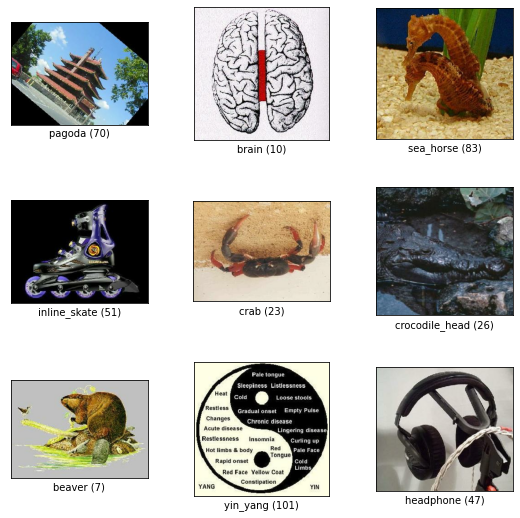

In [0]:
lfw, lfw_info = tfds.load(name="caltech101", with_info=True)
_ = tfds.show_examples(lfw_info, lfw['train'])

In [0]:
lfw_info.splits.keys()

dict_keys(['test', 'train'])

### Посчитаем медианный размер картинки

In [0]:
DATASET = 'caltech101'

In [0]:
# shapes = []
# for image, label in tfds.load(DATASET, split='train', as_supervised=True):
#   shapes.append(image.numpy().shape)
# x, y = int(np.median(np.array(shapes)[:, 0])), int(np.median(np.array(shapes)[:, 1]))

In [0]:
x, y = 224, 224
f"height: {x}, width: {y}"

'height: 224, width: 224'

### Подготовим датасет

In [0]:
IMAGE_SHAPE = (x, y)
TRAIN_SIZE = 0.8


def _normalize_img(img, label):
  img = tf.cast(img, tf.float32) / 255.
  img = tf.image.resize(img, IMAGE_SHAPE)
  return (img, label)


def make_dataset(batch_size):
  split_sizes = {k: split.num_examples for k, split in lfw_info.splits.items()}

  splits = ['train', 'test']
  dataset, test_dataset = tfds.load(name=DATASET, 
                                    split=splits,
                                    as_supervised=True)

  train_samples = int(split_sizes['train'] * TRAIN_SIZE)

  train_dataset = dataset.take(train_samples)
  val_dataset = dataset.skip(train_samples)

  # Build your input pipelines
  train_dataset = train_dataset.shuffle(1024)
  train_dataset = train_dataset.map(_normalize_img).batch(batch_size)
  val_dataset = val_dataset.map(_normalize_img).batch(batch_size)
  test_dataset = test_dataset.map(_normalize_img).batch(batch_size)
  return train_dataset, val_dataset, test_dataset

In [0]:
lfw_info

tfds.core.DatasetInfo(
    name='caltech101',
    version=3.0.0,
    description='Caltech-101 consists of pictures of objects belonging to 101 classes, plus
one `background clutter` class. Each image is labelled with a single object.
Each class contains roughly 40 to 800 images, totalling around 9k images.
Images are of variable sizes, with typical edge lengths of 200-300 pixels.
This version contains image-level labels only. The original dataset also
contains bounding boxes.
',
    homepage='http://www.vision.caltech.edu/Image_Datasets/Caltech101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=9144,
    splits={
        'test': 6085,
        'train': 3059,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{FeiFei2004LearningGV,
      title={Learning Generativ

### Создание модели

In [0]:
# keras.applications.MobileNetV2().summary()

In [0]:
INPUT_SHAPE =(x, y, 3)
model = keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False)

In [0]:
def make_model(img_shape, model=None, weights=None, trainable=True):
  """
  Создаем модель. По умолчанию - MobileNetV2.
  Если передан конструктор model, используется он (должен поддерживать 
  интерфейс keras.applications).
  
  Из созданного экземпляра модели (в котором нет выходного слоя, т.е. это
  feature extractor) создается модель, которая будет обучаться.

  (Добавляется GlobalAveragePooling2D и два полносвязных слоя с дропаутом).
  """
  if model is None:
    model = keras.applications.MobileNetV2(img_shape, include_top=False,
                                           weights=weights)
  else:
    model = model(INPUT_SHAPE, include_top=False, weights=weights)
  for layer in model.layers:
    layer.trainable = trainable
  input = keras.layers.Input(img_shape)
  custom_model = model(input)
  custom_model = keras.layers.GlobalAveragePooling2D()(custom_model)
  custom_model = keras.layers.Dense(256, activation='relu')(custom_model)
  custom_model = keras.layers.Dropout(0.5)(custom_model)
  custom_model = keras.layers.Dense(256, activation=None)(custom_model)
  embeddings = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(custom_model)
  return keras.Model(input, embeddings)

In [0]:
model = make_model(INPUT_SHAPE, weights='imagenet', trainable=False)

### Добавляем semi-hard loss
[Ссылка на реализацию](https://www.tensorflow.org/addons/tutorials/losses_triplet)

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tfa.losses.TripletSemiHardLoss())

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
lambda (Lambda)              (None, 256)               0     

In [0]:
BATCH_SIZE = 256
train_dataset, val_dataset, test_dataset = make_dataset(BATCH_SIZE)

### T-sne visualization

In [0]:
lfw_info.splits['train'].num_examples

3059

In [0]:
VALIDATION_STEPS = int(lfw_info.splits['train'].num_examples * TRAIN_SIZE) // BATCH_SIZE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6085 samples in 0.083s...
[t-SNE] Computed neighbors for 6085 samples in 5.955s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6085
[t-SNE] Computed conditional probabilities for sample 2000 / 6085
[t-SNE] Computed conditional probabilities for sample 3000 / 6085
[t-SNE] Computed conditional probabilities for sample 4000 / 6085
[t-SNE] Computed conditional probabilities for sample 5000 / 6085
[t-SNE] Computed conditional probabilities for sample 6000 / 6085
[t-SNE] Computed conditional probabilities for sample 6085 / 6085
[t-SNE] Mean sigma: 0.181061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.059227
[t-SNE] KL divergence after 1000 iterations: 1.188626


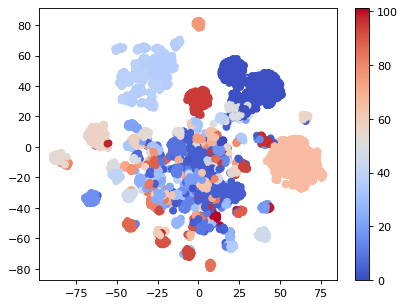

In [0]:
feature_extractor = make_feature_extractor(model, 4)
plot_feature_extraction(feature_extractor, test_dataset)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6085 samples in 0.086s...
[t-SNE] Computed neighbors for 6085 samples in 6.819s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6085
[t-SNE] Computed conditional probabilities for sample 2000 / 6085
[t-SNE] Computed conditional probabilities for sample 3000 / 6085
[t-SNE] Computed conditional probabilities for sample 4000 / 6085
[t-SNE] Computed conditional probabilities for sample 5000 / 6085
[t-SNE] Computed conditional probabilities for sample 6000 / 6085
[t-SNE] Computed conditional probabilities for sample 6085 / 6085
[t-SNE] Mean sigma: 0.206614
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.065353
[t-SNE] KL divergence after 1000 iterations: 1.799445


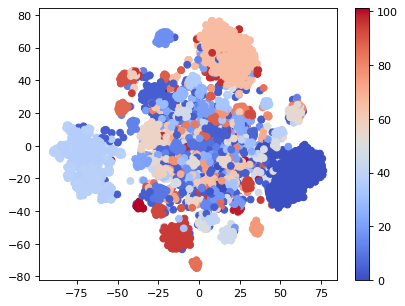

In [0]:
plot_feature_extraction(model, test_dataset)

### Training

In [0]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, 
                                               patience=3, mode='min',
                                               restore_best_weights=True,
                                               )

In [0]:
model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 13s 1s/step - loss: 0.9876 - val_loss: 0.8456
Epoch 2/50
10/10 [==============================] - 7s 702ms/step - loss: 0.9724 - val_loss: 0.7845
Epoch 3/50
10/10 [==============================] - 7s 707ms/step - loss: 0.9491 - val_loss: 0.7418
Epoch 4/50
10/10 [==============================] - 7s 699ms/step - loss: 0.9308 - val_loss: 0.7117
Epoch 5/50
10/10 [==============================] - 7s 707ms/step - loss: 0.9150 - val_loss: 0.6871
Epoch 6/50
10/10 [==============================] - 7s 710ms/step - loss: 0.8962 - val_loss: 0.6638
Epoch 7/50
10/10 [==============================] - 7s 707ms/step - loss: 0.8831 - val_loss: 0.6413
Epoch 8/50
10/10 [==============================] - 7s 707ms/step - loss: 0.8657 - val_loss: 0.6269
Epoch 9/50
10/10 [==============================] - 7s 703ms/step - loss: 0.8508 - val_loss: 0.6262
Epoch 10/50
10/10 [==============================] - 7s 720ms/step - loss: 0.8271 - val_loss: 0.6254
E

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6085 samples in 0.087s...
[t-SNE] Computed neighbors for 6085 samples in 4.716s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6085
[t-SNE] Computed conditional probabilities for sample 2000 / 6085
[t-SNE] Computed conditional probabilities for sample 3000 / 6085
[t-SNE] Computed conditional probabilities for sample 4000 / 6085
[t-SNE] Computed conditional probabilities for sample 5000 / 6085
[t-SNE] Computed conditional probabilities for sample 6000 / 6085
[t-SNE] Computed conditional probabilities for sample 6085 / 6085
[t-SNE] Mean sigma: 0.137600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.986267
[t-SNE] KL divergence after 1000 iterations: 1.107425


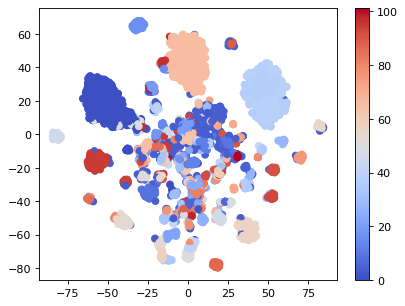

In [0]:
plot_feature_extraction(model, test_dataset)

In [0]:
vectors = model.predict(test_dataset)
test_images = np.concatenate([im for im, _ in test_dataset])

**Промеряем, что векторы нормализован**

> Для этого их значения l2-нормы должны быть близки к 1

In [0]:
np.linalg.norm(vectors, axis=1)

array([0.99999994, 1.        , 0.99999994, ..., 1.        , 1.        ,
       0.99999994], dtype=float32)

In [0]:
import urllib
from PIL import Image
from io import BytesIO
import sklearn

vectors = model.predict(test_dataset)
test_images = np.concatenate([im for im, _ in test_dataset])


def show_by_index(dataset, idx):
  fig, axis = plt.subplots(nrows=1, ncols=len(idx), figsize=(12, 12))
  for i, n in enumerate(idx):
    axis[i].imshow(dataset[n])


def preprocess_single_image(np_image):
  return np.expand_dims(tf.image.resize(np_image, IMAGE_SHAPE) / 255., axis=0)


def show_similar(test_images, vectors, vector, k=5):
  distances = sklearn.metrics.pairwise.cosine_distances(vectors, vector)[:, 0]
  closest = np.argsort(distances)
  show_by_index(test_images, closest[1:k+1])
  return vector


def get_vector(model, test_images, vectors, url):
  """model."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    pic = Image.open(BytesIO(jpeg_str))
    pix = np.array(pic.getdata()).reshape(pic.size[1], pic.size[0], 3)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running vectorizer on image %s...' % url)
  plt.imshow(pix)
  vector = model.predict(preprocess_single_image(pix))
  
  return pic, show_similar(test_images, vectors, vector)

## Визуализация работы нейросети

running vectorizer on image ...

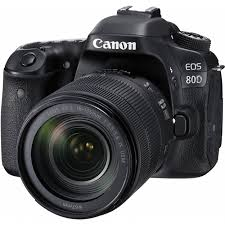

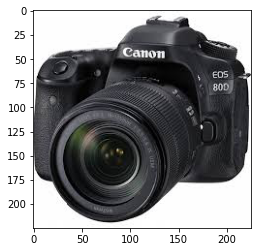

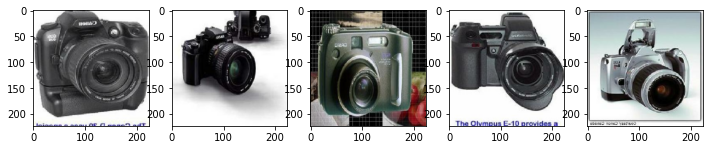

In [0]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUSExMVFRUXFxgYFxgYFxUYGxcYGBgXFxcYFxcYHSggGBolGxUXITEhJSorLi4uGB8zODMtNygtLisBCgoKDQ0NFQ8PFSsdFR0tLSsrLSstKysrLSsrLS0tLS0rLS0tKysrNy0rKystKystLTcrKy0tKystKystKystLf/AABEIAOEA4QMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAAAQMEBQYCBwj/xABOEAABAwICBgcFBAUKAwgDAAABAAIRAyEEMQUSQVFhcQYTIoGRofAHMrHB0UJScuEjYoKS8RQzQ3OTorKzwuIVU8MkRFVjZHSD0hYXJf/EABcBAQEBAQAAAAAAAAAAAAAAAAABAgP/xAAdEQEBAQACAgMAAAAAAAAAAAAAARECMRJBAyFR/9oADAMBAAIRAxEAPwD3FCRCBUJEIFQkQgVCRCBUJEIFQkQgVCRCBVFxekaVKz6jWmJibxyzWU9pfSB9DCj+TVB1jqga7Vc3WazVcSRnB1tUd5XkeO6TYqq1zHGA7PVY1rtn22jWMxeTeSrg+gtF6Yo4jW6pxdq2cdVwAO6SIm2WanrwjRvtDx1Km2m1zNVgDWg0miAMvdhXND2q4qBrUaDjvmoyfjCYPW6tVrRrOIaBtJgeJXFDFMf7jg7kV4lpDp5i6he91BjhBLYc53VjeATBgcF5vpXpHiarnPNV4dsIcQbXFxlcAwICYPrtCh6JxYq0KVUODg+mx2sLg6zQZHipagVCRCBUJEIFQkQgVCRCAQhCAQhCAQhCAQhCAQhCAQhUnSrTow1IxHWEdngPvH5bz3oIXS/pezCDUYA+ruPut/FGZ4LyvSvSXEYgnraznD7oOq390W+aqdMaSdUeSTJJ8ZzVcHLWIsi5p3LnVaobU8xBI6sLtmFnIFGHbdaHBMAbKDPYqk1jC17tUOEEA3I7slQuGHbZtIHndTOkFUmoVTuRXpHQj2nOwwZh67A7DtAawsAD6YGQjJ7fPicl6roHpbgsXahWa533DLXdzXRrcxK+YE3Sxpa6xLSCC0gkFrhkQRcfJQfXyF597M+nzMTh+rxVVjMRTgS9zWdc02a9swC7Y4DbBtrALf06gcJaQRvBB+Cg6QhCAQhCAQhCAQhCAQqrTPSLDYb+eqBpiY3Wm+62zNee6Z9sIaSKFEEbHPPHcMkHq6F8+Yv2q6QqG1VrBOTGt8AXA+gp56daVeIFjGZADuZDgI8PBXB7okLgMyF85v6V6SY7t13EzMEyBsiAcr7U1pDpJjqjYdWcB+qS3duPBMH0ccQwfab4hNvx9IZ1GjvC+acPp7EsENrVADn2ifiUzi9IV3w59Qvgz2r3gC85iwtkmD6S0hpyhRpPrPeNVjS4m94EwDvOS8OdiMRjya1V7y+o61NmXBrREkAWWQrY+rVhr3ktBhrQA1oJzIa0ATneNq9T9mmJpUKzOsIbrMLWudkHGIknKQCO/igxmk+j9aherSqMByL2uAJ3Tv4KreI2T+99Vva2AxbHVaNRjWdfUY2pXqXDw57Q3qy4w65Luz2uIhXGl9B0RhcUBhWdZhXBwc6gaQqNaBrnWY/WqMgkzIyCujyU4qPs/wB5yT/iYH2XfvD5tXrunui2AP8ALGDDspFlGi4VAXdgvLxrBs6rY1ATvkyqjSvQ7BMbjaTqeq7C0WYim8Pe11Smabi5tQu1hJqUarZDbazYGxNR55T06G7H/wBw/wClXGG6Wy2A3xb8w8R4LaU+gWjHuY3qKjS/CmtatUIBlo23Lu3v1ez7q8c0dUy4gIJ+kMWXuJgeJ+ijSd3mnK7UwHEIOKlRwMQm69JvUl+vFQVQCywljmGHN2khzCDuDmqSak5iSnaeFZVEAwTssDPCUUzozT9amAwO1qYM6jpIBiJaR2mGLSItaVocBpXCP1ZfiMFJ7bqTn1WkXLg3tgMkibh/ABZXFaLqUjD2kDYSInx+oXLbXOe/f32JyO05qD1fRWmNI03OGFx9CuwXb1tQ3APuuY+SD+ENFswtroD2hh9PWxdA4Y6xbOsHC0XjMcrkxabT88MqEevW53ip2Hxjxk47sz9UH1dg8UyqxtSm4PY64c0yDs+Nk8sR7HsOW6ODj/SVajxwAIZ947WE7M8tp26gEIQgFjPaB05ZgW9VTh+IcJA2Uwcnv+TdseOj6Q6WZhMNVxD7im0mPvOya0cS4gd6+a8Zialeo+vVdrVKji5x4nYNwGQGwABWB/SHSjFVLOe05502Ou7P3mkknbvUCnXM9uoyn+GlTcRz1G2PCZUTEvGW35C59c1K0NQp601HBrRmSYCqO65Nv0gqtORvB3gtIlpG0ESE7QwbINUPdadZrjrXdEkE7Lea4ovFWtVewRSBDaf6wbbWO8n6bkzp93V09UG7vh6+CCSNKUWOBid4SY/S9MyGCxWNqPKKbypqrcY26mvxg1FUvwVRrBVLewdvwlN4cOfUawfaIHigdxOLcwjVsc043pJiAIL5HEKZjtF3KrauBIQSP/yOrtDSnz0srGZc+7dU9t12/dN7tubKmfhyElPD7SgvKvS/EODw6tXIeA14NV5D2iYa8E9oCTAO8oxfS/EVKQovrVXUwANUumzTLWk5uaDcAkgbFRuotTZphQahvT7GggjE1ART6oGGGKdjq3blYXztmqXD4xjVXFqAEGlp4yk8e+AeKSrSMTmN4us4GqZgcY6mbGRtByKuiyaum2KCWmHN90+W8JzVkeaqJuH0rVYIa8gbsx+6bLipjqbvfoUjvLQaZP8AZkA94UGrbvTYovIkNcRMSAYk2AnffJBMNHDO901KR3OIezxABHeCmHt1Ns+Hxsu6ejK5dqCjVL4nVFN+tq5TqxMcU1iaDgDIILTBBsRsII2QUHrHsx9pjGCjgcU0MbAZTqg2BJMNqybSftC1wCNq9lXxoV9N+yfTT8Voyi+odZ7C6k50yT1Zhpd+sW6pO/Pasq2CEqEHk3t80u9lLD4drSWuealQzsYNVjSNxLiZ2Fg3rzB+LaWSA4cwY8RZege3GsW4qjH/ACL973/RYPRnSJ2HnVBaDmBBHcCCArBVNkkEFwIMhzSQQd4IuE83RjXu1qkuPEgDwELvHaYZUJLhB/CB8FV1TTO0+X0VRoTj6VMQCCRYNbHxFgqLTdUu7Tsz5DYAo9MMaZkpcVig7MTCCrcJyXVGWkERIII7rpa9cmy4pNWVXWI0oXUBRDYFiTM5XACXotSmsXnJjTH4ndkeWse5QgICu+jNAikXfecTOVm2F+esqLaoQVBxFNuZUsdWDL6pI3MbOwSSTG/4cUxia1I5MP7Rkzu8N3dIuqioxNMROzfmPJQqtE3Ei2yH7pH2VdMp0puyReIMfDM8rDfsSPoU3EmIBNgMvwiIBjhZBnquGcGgyDMQAHzfm0DzTbsLUidUkASS3tAAZkkZLUN0UM2uINxIvzEqLidBPnWDiDvbw4ZqYrNFyAVaY3RldztZ0vJgSL2AgTuso9TRNQbFBFBXYTT2lpgiEoegstH1M277jmPyWhGBijSrNMteXscL9mowzq5QQab6brE5mYssrhqsOB4haCi0hjnF4DWHInNzrWG+GiTuAWoFr0R4XHL8pPktBo7TVJjcIS5o6rVD26+JDhFZ7i5lNo6l3ZcHS4zM7QFTs7eryJ8IEefkrKh0dNSh1zakEuLQNXsa2vSY1jqmtao41QWt1bhpuEQuD0rTZRbh3YllUTUc8vp13NIJoljRJY+Q6m92YHa2yq/FNpONY0xq0zrmm0mSGyS0G5kxG/mVcno9RZrVDWe6k0VIhgDy6lV6p4DdYjVkhwM5HKU7jcL1VKsyQYZZwyIc0Fp8HBBjcHgWE/pavVjZLXOnnHu7Ni9L6M6OxNSlSw+jsbRYTNSoKbntc0HUaalYaxOtkNURJMGMx5pVJ1o2La+xvE6mlabZ/nKNanzs2p/0lFexf8Bxn/iVX+yo/RC0aFB4t7Zr45g3Ydn+ZVXn1fBcPXG0/wAVvfas7W0i79WnTb4guy/aWZdStv2xu5z3X4DvsGVrYSNgn0byZi45qM+jHh8yFsnaPpOoBxjWMkmACDJgAgCIsBG5ZfFMiL3j63QQdRRK7lYxZVmKQMqXgaRcQGgk7gpWj9COfDqh6tnH3jyHrktFg2U6Y1abTxgSTzJufBJBCw+iBE1L290GB3n6eKndWAA0QGjIN2DbHH8uSKmIAza/v+sBNjFUjmH91/WfqAqg1R/AbfjGfHONyBSbv8ptnkLGdgFjxhKKtA260tO5w/hu+ed047BkiWlrxfIi887fHiHG6o4GGm9ja952kAGPe90wLN5wlNDOdmcmI/E4WH4W/NcOYQYIIdxBByic5NpyMxm5osnaeJIgm8S4e7x7Qns/tWaMgXEqAawtIiQYtAh0bdVv2G7JPfsUihios6IEAkZMAsb/AG3n4+fIc2DGViRJbrE/aquPaDbGNkc4XNUbZFrBxFhwpM28/jkglPY13aFiROyYmO0O7bdQ6hgw4d+wpptUtO28EtntPjLXOxvD+C7fWDmnh70ZAkmwO2N6KTTmDwxphrTr1JJJbMahiCQfdIJA5lY3FYUtPDetO3EuYTG3PK8TY9zjwuVCxFNrp2Ddc8vJBRNWkoOOq14Me6TwBgE8x2vBZ6tS1TCtsHUPVN72nuM/NSC40XeANhI7i0/krR+nqlKkKTQ0Foc1r9Y9kPe2o7sTql2swQ4iwtsEU+DaNQjiPiFEqsA3bfh68VUXp6RFxh1OgGEOGoS+JfU617gdfWBLuMQAIT+N0kH0yA5rnPILoyABBi3ICBsWapu+Xr8+Kl06gBjf9BkggE9rvPlZaP2aP1dLYIjbUeP3qNQfNZxl77yT5lX3QAxpTA/13xa4fNB9PoQhZV4P7Q6utpPEHcWAcIpsH1VRWqQwi8xuHHjfdyKkdLqpdj8UZ/pqg2fZdq/6QoLnE57jPfzOWz+Cog16pykgS4kc+1bcDdVuME9wtw4eM9xHfPxDvrs3Ddndyh4ikTDWi5y9dyqINOkTYCSVZYHRAadY3dnMTHIZN5lW+H0a2gzWfnnAN+8/ZHFV4xz6ztWg0EA+9kxvLa8+pQSHlrcmax3ntTxEwP8AEoVbGVHdmQOGsB/dYArfDaFm9RxqE7DZt9zRnffKmtpNaQBAbsgR5KjK9XU+8e4P+qR2tteP2gT5EGVqjqyPPNMta2Ydl+Y+UoMy+k/Lq2u/BY89Vst8WqMzUB7LjTdxOr5+6e/VWmq6PpkmI7rbfDjtyUfEYdw7L2trM3P96JjsvEObly4FQVo0hWYNWo0VGxJEXDfvFm79ZpjipNGrTq3pOub6riCSd7XHN2UawJGyU1/w8xOFLngdp2GqfzjTcl1FzY6yL3ZqvtdsKoe5r+2w6rvtZD98CxH64H4gM0FzrxwiSbkEbCSTdu4udLjeAErsQRfK17XaCZljSYZsAbmd2wwcPpHX7L7PbkT4Xz7nZhPE90crbzt1c7vMk7EDrngi228Ay53FztgTHWEG0SP3W/UrgmJ+6buAt3jaBzuc0j91uQ91vM7SgWtcSMuPDhuSYWgajgwRJsJMDfcrkP35HM7Twami4tdnBBBnccwUE3pPoZtIBocXOFn7Q132bjKRMA3sqzRx/REbn/Ef7VdVMT1lDq6dLVsDWdNnObtaM9Y9kn5SqnA0iRUaNpYe+SPmoLLAnskcE3iBfP0JkpjqH5NMngfjtlMVaT25nmFQ5rx5eY/LzTuGqSZ3An5/PyUSo7WE7s/XgnME4w+Punz/AIBB3QbYcvkrvoYSNI4NwMEYikNmTnBpz4OKp6e1XHQq+kMJ/wC5o/5jUH1GhCFlXzfp8zjMSYH8/W/zHeu9R3m2Xr4A5eCd04P+14j+vq/5jvBMPJ2+F4+InbfiVoQq5kgbwM95sY8fLxnYKk2kw1ndmxgmLC9/xGLcuAUXC0Ose1uzbfIC5J3WtOxV2nsYcRWGHp+4DHMjM90DwA+yEDlEVMbU1RLaLecu5+vy1lDCNpNDWACNyTRmCbRphoGy53+rqsxWL64mD+j4fb/2/FTlynGbUtOY3TAEhgmNsw0cJzdyHiqPE6YeciT4tE8A3tHxT2KpE8hkNyfwmh7a77cD8CBc/hHeVz4/Jq8ZarKdWs4/7QY+JHe4KTSqO21GzumnPkXJzGsDdjWgZF8GOTfcb3DvUM4h5yq1f2Wvj+6IXQT6WLcCBrBx4Fk/4gfJTKOOE6p8CIttzF+fLcqQ9dFqriN1Rpj+8mnYss7NRmoN7bs72ZDugq6i8xdBhAIJm0bwRcEHZsPPI2VJpmm5zusNqv3xbrOL/wBf9bbN95mUcREfaacrz+6cz+E35qZVDajSSZ3R4Du2IMXVcQ6Dbcd35fBWeBxWsNU5jL6Xty3FcaTwRBLSOXBVlJ5B4jzH5KKv5+vftN8zvccti4jZmMwNnGTmQN/0XFGprAHfwm/LbyNpThv/ABzO2+3cTkFUNE7Z7/k1I8SOXw3njKVx2+ewcAN6GDZv9SUEnQ1bVc4HIi8+t8HuTdOhVJrOw7DUDG67nNEhjA9svd+qJv45AqE4Kw0Ppyrhet6uP01J1B03htSA4j9YDKVFRP5MwyS+oHHbDCJ4ixhIx7jrNd7zM+IsPmEsrsn9M7+pZ/hZ9EQUG5jgVzgM3/gK7om55fmk0aBLuXx9QgfZkVcdBm//ANHCf19PyeCq2jhpBDbarS4zwVx7PmTpPCf1w8g53yVH00hCFlXzbp+2MxP9fWvb/mO27FFJjyz1b5WgRw8e9TekoAx2KH/qK2wf8x29QSfQt9Qf4LUDFbE9VRqVB7zjqMO7f8QY5qP0JwOs51U5CwUTpLXtTZOTNY83ZTykrT9GKGph27z809iP0kx0atBpu+7uDMo7z5AqKKoADRsVRicXr4io/ZrEDk3sj4T3ruhiJd3rj8k8mK1eisIHOk5C/f685U7ShDW2AmO5o9eKhYDFBjJ7+eweuKjV8dMkrMmOs5ZxZjST3a20u2b+7d3Ksq0jN3Nnddzu8gEDvKtcdJfqtzdYnns5b0zpHDtpjVGe0rfl6Y7+1YzWaZBg+BU7DaSPuvEg+u9QqdBznBrWkuJgACSSdgCSowizgRzWtFlVp9V26fapH3mbuI3fL4WGExORBkG/ObTwM2PGDZVeisVqnVNwfhtTzafVVDSzYRrs5HNvhPgFoWuPohzZJ7R9d19nBZbHUiDrDMZrWYSsdUtAk5bzvtzEKq0jhrkG0i/z8r9ytFdo6pfV2G49cCrH1+XHlkNqpaJLc82OvyNj5/FXjx5/PZ4gmNu1RSVxkRu4QM920nWUeY9eZUp5lnI79/xNjkNp3KI/1+fFVCVxc8yo9U5Hc4E8gVJrZ+HwXVPsGRcx3XUDTnjeEgrgve/YWtY3kNUT4N805S0bImQO5KcK0bz6v64IrhtWxPC3z7sx3p7Rg978KYqmb+tykYExrHcERMZWI1ojtAjxjzV17M2k6Vwf9Y4+FGqfks8wkySZWv8AZC0nS1D9VtVx/s3N/wBStH0ShCFlXzn0ubGPxf8AX1Ng2um/iqt4tGXn5ZHPPgrnp4yNJYnP+cnZta05ZnNUtgM/pvtB8rbFqDOdIHzWeNksA4CAVuKVXUw2t91hd4NJWB00f0z/AMQ+C2lXtYR4GZpO/wABSIxGDMNT2FqXCjYZ1ktF0FZsGkxeJIptH4R4N/JRBi8uabxdSaTTuj4ap81X9b5H18FMSpLcRD9b1tT9XCF1M1y4WdEbVUuddO9cS2J5hSxYnPx3VV2VqJgsuDuMQfiUaSx1OpSA1P0pcHF8nLtSI4yP3VWMddOVYJss+E2frW3DbTBB3FXWkmzRpVdtOpqk8Df6Kn1JstBXZ/2Csf8AzmAeLD8CujLrDmPW4kfCEuNk9pwgco7O4cItyQ0QPXrYnsUyWAwbxfsXtfK5uNq0Mvi6UVS37zSOZAP+pqssM7WpMPAj4fQqJpL+cpHbLZ/uO+LipGAH6GNzyP8AH6+uSingbO7jv2EbuOduAgKG8+vXxUmbHkdsc7/Hb32ETM/l8vkiJLPtEidUWm95AEbzAcm2jILkAm2zM90/UpyjcoJzTAA7/XmoVZ3rzuO5P1akD1lBUV/19eaBqp8LeHrzUjC+6/l670zUac/W9O4f3XbyLcxkPW9A5TyJ5/GF657CtAtJq49xOsJoMbFgCKdR7p2k9kDdBzm3klE7RtC+gfYxQDdF0z9+pVd4PLPgwJVblCEKDwr2t4E0tIOqEQ2u1rmmc9RrWP7xAng4LJB9iB5dx3yvfPaD0SZpHCmlIZVYdei/7r4iHRfVcLHuOYC+c9M6MxuCeWYqk+mcg4gljvw1B2XTwKsFV0gZ+lcfvBrvID5LWdH6wfhwDugrLaRd1jG1NoJaeRuPmp/Q/FwXUzzCs7RRMYWOcw5tJB5gwVyTBVp0qwvV1+sHu1L/ALQs75HvVZUCgs8KdZhZw9ed+9VxkEg8iu8HWghTcZhtca7M9o+XP4hBXFs227OI4cVyHLoXt5fT6Lqd8HnY+KgTW4Bd0wTYD8uZQAPu+LreUJ+m2eW4WHeUDlFozGQyO87Xd2fcFpdJ4Ysw2FoEQ6o413jc0e6DxgsH7JS9FNBtqA4qv2cLSuXEH9K4G1Ngzc2YB3ns5zEnFVHVqr67xDnwGtt2GD3WTvuSeJKIrXM8gT4A/N3kmqlYkBsAwRFr+O5S8RYHjA+f1PeFDpe8OEk8mguPkFqKpdJntU/xD/QpVB00i771RzvN/r5jNQMe7tt4QT3NE/4VYNZq06bdobJ7/wCBUU289k9wy9R6skwtGSTsHl6Ep0UiSB69esrGd/wwkAOOqzNw2uygcBv7t0kK5o1gXDLIcRv70rbKfi3NFmiAMlU1HmVQ/Ud68U20JsVOC660bioHmDZ69H6KXToAXuoDcQOPkr/ozonE45/VYWkXCYdUdIp09+u+ImPsiSdgQRej2h6uJrtw1IS97oFrNbmXnc1oN+4ZkL6f0NoxmGoU8PTnUptDROZ3k8SZPeqjoV0Oo6PpkN7dZ8dbVIguj7LR9hg2N8ZN1pFAIQhALl7ARBAIOYNwe5dIQeee1LoVQq4KpUoUKdOqztksY1pe0TrB2qLx737J3r5xoVjSqB2RaYK+0CJsV80e1voccFiS9jf0FWXM4b282yBy1TtKCLjqDcTQgZ5tO5302d6xtOQSxwhwMRyzCtej+kurPVuPZORU/TuietHW0/f2j7w/+y12jNOEXU/A4qPWfr+G5Q6T5sbOyg2k/I8EppEXHgoLqphqVW57Lt8/PI8jBXB0FW+y5rh+tI+RUHDYuLG3r4eXBWeHxURBjkY+bR5IO8P0ZxDj/Qt4k/7StBgOjuFow/E1DiHC4ptGpT/aM9ru8CqpuMd9537y7pVZyv3z8NY/BMGg0jpJ1ctmGsZ7lNtms2SBtMW1jsyDbywKc+tn0+KiYR08d+UDnmPEk8EukMaILGnmd53D658tkTtAx9bWdAyHmdpTGrFN7yYFmDm6S49zGu8QuSovSPEagbQGbZ1vxujX8AGs7itKqabTUqczfvu7+6FdOEknZkO631UHQ+GJMj3nWHzK9y9nfs8FPVxOKb2hBpUj9nc+oD9rc3Zmb2EVG9nfs2Yaf8oxrCS4dikSWkD774gg7hsnlGuqezrRh/7ue6rWH+tapCgxb/Zbow/0Tx/8tX5uTDvZLov7lX+1ct2hBg//ANR6M+5V/tXJyn7J9Fj+ieedV/yIW4QgzGD9nui6dxhKbvx61TyeSFpKNFrGhrGhrRkGgADkBku0IBCEIBCEIBCEIBVXSbQNLG4d1CqLG7XbWO2OHjltBIVqhB8i9L+jFbA13UarcrtIyLTMOadoMHwO0FJofS+rDKh5FfSfTnoXR0hTvDKzRDKkTbPUePtMnvBuNoPzl0l6K18HVNKrTLTcgZhw+9Td9puVxltAKolaS0XTrjWHZd94bfxDaqOvhq1H32a7fvC8DnmORC7wWOfTtdzdxzCvMFpKm+LxcTvjaqigpVKT/tDk63mJHwUuho+fdMcnA/4SryvoqhU+4d590577HK6hno3TOWsMrB5tMZzlmPPcUDdPAu+8e8wnjVoss94cdjZLz+6JKZqaEptJa4OMbC50eScpUGM91obyCBx+Me8Q0GmzwefD3PM8k25DnbPXcF3VqMojXqgOd9mlvOw1IyH6u3gEHYf1LOuPvkHqm/GqdzReN5vkL5mnSdUfkSSYAgkmTAAGZJOxWJGIxlVrGMdUqVL6rbudeAIFmUxHKwOUR7v7NvZqzBauIxOrUxUWAu2jIiG73xYu7htJimvZh7Pf5M1uJxTR15ALKZg9UNk/r/Dnl6ShCgEIQgEIQgEIQgEIQgEIQgEIQgEJUIEQhKgRQdMaIoYqmaVem2ow782n7zXC7XcRdTkIPE+lfsgqtl+Ed1zc9RxDao5Os1/90815npDRL6T9SqxzHj7NRrmP5iYJHG6+uFHx+j6NZupWpMqsP2Xta4eDgro+S2Co3Iu74d9FI/l9baZ/f2dy9/0h7K9GVCS2k+iT/wAqo9o7mklo8FS1vYrhT7uLxTeZon/phNHjZxbzcgT3/MBcuqx7zo5evmvZqPsUwgPbxWKdwDqTR/lq80Z7LNFUTP8AJutO+q51QHmwnU8k0eBYE16x1MJQqVHZEsY55HMgW74Wx6PexrG13B+MqNw7drbVKh3iAdRvOTyXveGwzKbQymxrGjJrQGgcgLBOKCj6LdE8JgGamHpwSO3Ud2qj8vef3ZCBuAV4lQgRCEqBEJUIEQlQgRCVCBEJUIEQlQgRCEqAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCAQhCD/9k='  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
pic, vector = get_vector(model, test_images, vectors, image_url)


running vectorizer on image https://www.zeiss.com/content/dam/consumer-products/images/photography/_home/_vario-teaser/zeiss-photography.jpg...


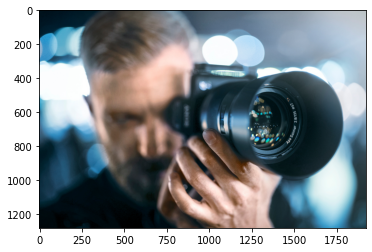

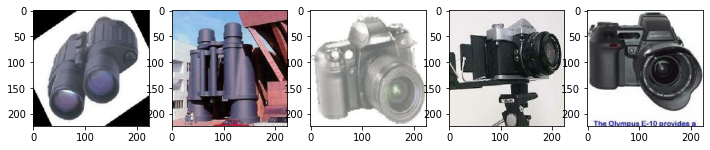

In [0]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://www.zeiss.com/content/dam/consumer-products/images/photography/_home/_vario-teaser/zeiss-photography.jpg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
pic, vector = get_vector(model, test_images, vectors, image_url)


running vectorizer on image https://i.pinimg.com/originals/33/53/77/335377f3ba512726cc4e67b8fdc7a3b8.jpg...


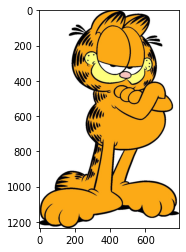

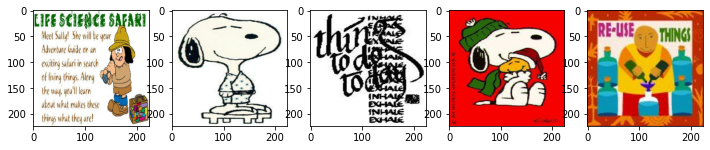

In [0]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://i.pinimg.com/originals/33/53/77/335377f3ba512726cc4e67b8fdc7a3b8.jpg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
pic, vector = get_vector(model, test_images, vectors, image_url)


running vectorizer on image https://m.media-amazon.com/images/M/MV5BMTUxMjU4NTM4M15BMl5BanBnXkFtZTgwNzczMDY5MTI@._V1_CR0,60,640,360_AL_UX477_CR0,0,477,268_AL_.jpg...


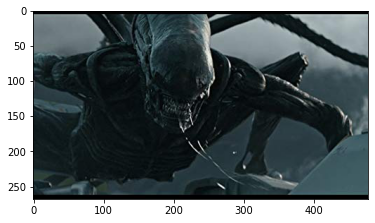

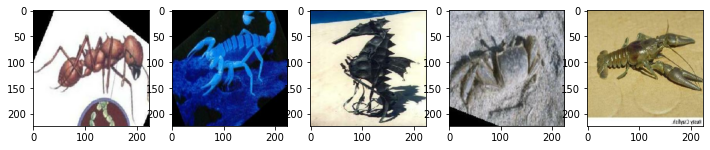

In [0]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://m.media-amazon.com/images/M/MV5BMTUxMjU4NTM4M15BMl5BanBnXkFtZTgwNzczMDY5MTI@._V1_CR0,60,640,360_AL_UX477_CR0,0,477,268_AL_.jpg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
pic, vector = get_vector(model, test_images, vectors, image_url)


running vectorizer on image https://www.denofgeek.com/wp-content/uploads/2017/02/alien-main_2.jpg?fit=1440%2C900...


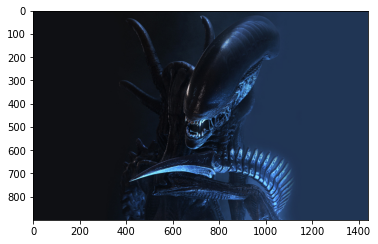

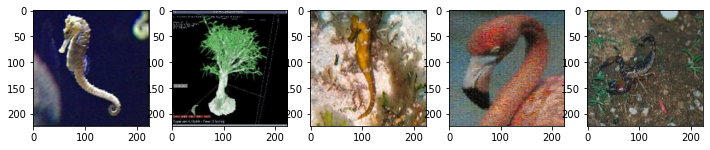

In [0]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://www.denofgeek.com/wp-content/uploads/2017/02/alien-main_2.jpg?fit=1440%2C900'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
pic, vector = get_vector(model, test_images, vectors, image_url)


running vectorizer on image https://ichef.bbci.co.uk/news/1024/cpsprodpb/8FA8/production/_111167763_mediaitem111167762.jpg...


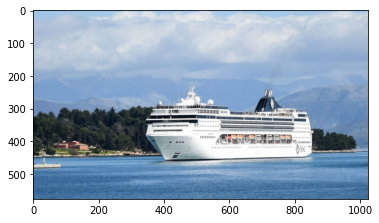

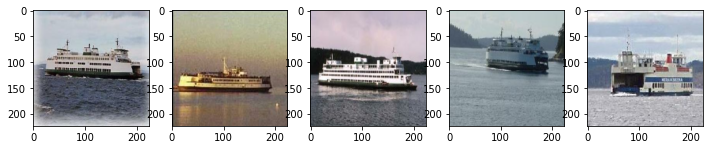

In [0]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://ichef.bbci.co.uk/news/1024/cpsprodpb/8FA8/production/_111167763_mediaitem111167762.jpg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
pic, vector = get_vector(model, test_images, vectors, image_url)